step 0
s: 100
agents_w count: 10
step 1
s: 99.9996
agents_w count: 10
step 2
s: 99.9992000016
agents_w count: 10
step 3
s: 99.9988000048
agents_w count: 10
step 4
s: 99.99840000959999
agents_w count: 10
step 5
s: 99.99800001599995
agents_w count: 10
step 6
s: 99.99760002399988
agents_w count: 10
step 7
s: 99.9972000335998
agents_w count: 10
step 8
s: 99.99680004479967
agents_w count: 10
step 9
s: 99.99640005759949
agents_w count: 10
step 10
s: 99.99600007199926
agents_w count: 10
step 11
s: 99.99560008799898
agents_w count: 10
step 12
s: 99.99520010559863
agents_w count: 10
step 13
s: 99.9948001247982
agents_w count: 10
step 14
s: 99.99440014559771
agents_w count: 10
step 15
s: 99.99400016799713
agents_w count: 10
step 16
s: 99.99360019199646
agents_w count: 10
step 17
s: 99.9932002175957
agents_w count: 10
step 18
s: 99.99280024479482
agents_w count: 10
step 19
s: 99.99240027359384
agents_w count: 10
step 20
s: 99.99200030399275
agents_w count: 10
step 21
s: 99.99160033599154
agents_w

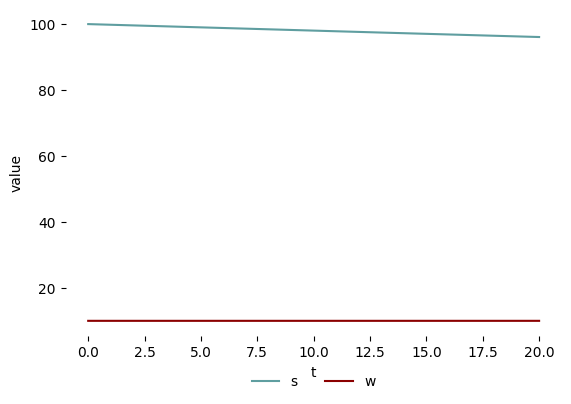

In [12]:
# subliminal wolf ABM: this time it's personal
# v0.1.0

# Same setup but with price-sensitive wolves
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd

# throttle
throttle = 7500

# Not converting sheep from the ODE for now
model_params = {
    'alpha': 1,
    's_start': 100,
    'w_start': 10,
    'eps': 1e-6
}

agent_w_definition = { # here for convenience
    'w_beta': 0.1,
    'w_gamma': 1.5,
    'w_delta': .75
}

model_state = {
    'step_accumulated_ds': None,
    'step_accumulated_dw': None,
    'state_s': None,
    'state_agents_w': None
}

# time params.
model_time = {
    'time': 20,
    'dt': .002,
}

def set_tmax(model_time):
    time = model_time['time']
    dt = model_time['dt']
    return int(time / dt)
    

#############################################################
# Agent Functions
#############################################################

def process_agent_step_w(agent_w, model_state, dt):
    # process_agent_step reads the state of the agent, the state of the model. since this agent is not mutable
    # (it probably cannot be if we deterministically migrate from an ODE)
    # the agent can only operate on the state of the model.
    # as such, this function outputs accumulated changes to s and agents_w in an approach that
    # approximates the ODE.

    # unpack
    s = model_state['state_s']
    current_step_accumulated_dw = model_state['step_accumulated_dw']
    current_step_accumulated_ds = model_state['step_accumulated_ds']

    w_beta, w_gamma, w_delta = agent_w

    #### original notes
    # for now, i am leaving in quite a bit of commentary.
    # we cannot just eat sheep here. if we do, it is impossible for us to simulate the effects
    # that are seen in the ODE. there are a number of possible workarounds, some of which i dicuss below

    # wolf eats sheep based on same formula, just individualized.
    # ds_dt = alpha * s - beta * s * w
    # dw_dt = -gamma * w + delta * beta * s * w
    # we are definitely going to run into a data chunkiness difference here.
    
    # recapitulated wolf function from the ODE
    dw_dt = (
        -1
        * w_gamma # gamma
        * 1       # this here wolf
        + w_delta # delta
        * w_beta # beta
        * s       # sheep
        * 1       # this here wolf
        )

    #### original notes
    #  let's look at this really closely under the lens of 
    # model variables and agent variables

    # we effectively need to process changes that affect other *agents*.
    # there are two primary ways to do this:
    # we could have a model-level variable that is basically wolf_agent_count
    # this seems possibly effective but the problem is that technically a model-level var
    # should only interact on agents individually
    # in other words we would need some "wolf pressure" and a function.
    # not necessarily a hack if we formally tie it back to the ODE!

    # we can of course also affect other agents directly
    # with the output from this function.
    ####

    # for now our approach is to have the model-level accumulation of changes to state.
    # interestingly, these accumulations are intrastep, since all the wolves process at once.
    # however, taking this approach allows us to stick to the idea that the agent itself is responsible for effecting change
    # at the step runtime. in other words, it keeps the agent "doing" something.

    added_dw = dw_dt * dt # scale to dt!
    model_state['step_accumulated_dw'] = added_dw + current_step_accumulated_dw

    # calculate the change in sheep using ONLY the contibution from THIS wolf

    ds_dt_one_w_only = - w_beta * s
    model_state['step_accumulated_ds'] = ds_dt_one_w_only * dt + current_step_accumulated_ds

    return model_state
    
#################################################################
# Model Functions
#################################################################

# make a wolf. its beta will be set just like in the previous model.
# at some point, this might be the place where we would reintroduce theta
def instanitate_agent_w():
    return (
        agent_w_definition['w_beta'],
        agent_w_definition['w_gamma'],
        agent_w_definition['w_delta']
    )

# make all w_start wolves
def initialize_agents_w(w_start):
    agents_w = []
    for i in range(w_start):
        agents_w.append(instanitate_agent_w())
    return agents_w

def reset_accumulators(model_state):
    model_state['step_accumulated_dw'] = 0
    model_state['step_accumulated_ds'] = 0
    return model_state

def process_agents_step(model_state, model_params, dt):
    # this function will process all agents sychronously and return the new state of the model

    agents_w = model_state['state_agents_w']
    for agent_w in agents_w:
        model_state = process_agent_step_w(agent_w, model_state, dt)

    return model_state

def ODE_accumulate_and_fit(model_state, model_params, dt):
    # this function will need some attention, but the primary goal here is to accumulate the actions of individual agents
    # and then use them to create a smoother model-wide change.
    # there is a TON of formalism needed here, i believe
    ds_total = model_state['step_accumulated_ds']
    dw_total = model_state['step_accumulated_dw']

    # Apply ds_total to sheep
    s_candidate = model_state['state_s'] + ds_total
    s_candidate = max(0, s_candidate)  # no negative sheep
    model_state['state_s'] = s_candidate

    # Convert dw_total to integer wolf births/deaths
    agents_w = model_state['state_agents_w']
    net_agents_w_change = int(dw_total) # that very innocuous int() is important!

    if net_agents_w_change > 0:
        for _ in range(net_agents_w_change):
            agents_w.append(instanitate_agent_w())
    elif net_agents_w_change < 0:
        # remove that many wolves from the end
        remove_count = min(len(agents_w), abs(net_agents_w_change))
        for _ in range(remove_count):
            agents_w.pop()

    model_state['state_agents_w'] = agents_w

    # 3) Optional correction (eps)
    eps = model_params.get('eps', 0.0)
    # TODO, this would be an upportunity to push off of zeros
    # model_state['state_s'] = un_zero() ...

    return model_state

def process_s_euler_forward(model_state, model_params, dt):
    # unpack
    alpha = model_params['alpha']
    s = model_state['state_s']
    # this model function operates on the model-level population of sheep, and model variables for sheep
    ds_dt = (
        (
            alpha    # model, not agent, variable; operates population-wide   
            * s        # sheep count
        )
    )
    # send value with which to update model_level sheep variable
    # don't go below zero
    new_s = max(0, s + ds_dt * dt)
    model_state['state_s'] = new_s
    return model_state

def process_model_step(model_params, model_state, dt):
    # agents move first, arbitrary
    model_state = reset_accumulators(model_state)
    model_state = process_agents_step(model_state, model_params, dt)
    model_state = ODE_accumulate_and_fit(model_state, model_params, dt)
    model_state = process_s_euler_forward(model_state, model_params, dt)
    return model_state

#################################################################
# The Model
#################################################################   

# Simulate with wolves
def run_agent_based_model(model_params, model_state, model_time):
    tmax = set_tmax(model_time) # tmax = int(time / dt)
    # unpack model params
    model_state['state_s'] = model_params['s_start']
    model_state['state_agents_w'] = initialize_agents_w(model_params['w_start'])
    # unpack dt
    dt = model_time['dt']

    # the stores record model functioning over time. initialize them using model state.
    s_store = [model_state['state_s']]
    agents_w_store = [model_state['state_agents_w']]
    t_store = [0]

    # iterate over steps
    for i in range(tmax):

        print(f'step {i}')
        print(f's: {model_state["state_s"]}')
        print(f'agents_w count: {len(model_state["state_agents_w"])}')


        # process model step
        # note that our model processing doesn't need the step number; just dt
        model_state = process_model_step(model_params, model_state, dt)
    
        # make a record in the stores
        s_store.append(model_state['state_s'])
        agents_w_store.append(model_state['state_agents_w'])
        t_store.append(t_store[-1] + dt)

    # Generate a model return
    xdf = pd.DataFrame({
        's': s_store, 
        'w': [len(agents_w) for agents_w in agents_w_store],  # just get counts. list of lists.
        't': t_store
    })

    return xdf

#################################################################
# Notebook Work
#################################################################

# Run the model
xdf = run_agent_based_model(model_params, model_state, model_time)

# Plot the stabilized system
sns.lineplot(pd.melt(xdf, id_vars=['t']), x = 't', y = 'value', hue = 'variable', palette=['cadetblue', 'darkred'])
plt.legend(frameon = False, ncol = 2, loc='lower center', bbox_to_anchor=(.5, -.2))
sns.despine(left = True, bottom = True)
plt.subplots_adjust(bottom=0.2)
#plt.savefig('hungry-like-an-agent_LVtimeseries.pdf')